In [97]:
import csv
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.svm import LinearSVC, SVC
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

In [98]:
test_binary_labels = pd.read_csv("q3_test_binary_labels.csv", header = None)
test_features = pd.read_csv("q3_test_features.csv", header = None)
test_multiclass_labels = pd.read_csv("q3_test_multiclass_labels.csv", header = None)
train_binary_labels = pd.read_csv("q3_train_binary_labels.csv", header = None)
train_features = pd.read_csv("q3_train_features.csv", header = None)
train_multiclass_labels = pd.read_csv("q3_train_multiclass_labels.csv", header = None)
truePosC = 0
falsePosC = 0
truePosG = 0
falsePosG = 0
presC = 0
presG = 0

In [99]:
CINT = [0.001,0.01,0.1,1,10,100]
GINT = [1/16,1/8,1/4,1/2,1,2]

In [100]:
#Q3 Part1 deciding C value with 5 cross validation

#that function is special for our data
def five_cross_folds(arr):
    fold_arr = []
    fold_size = int(280 / 5)
    for i in range(5):
        given = arr[0:i*fold_size]
        given_rem = arr[(i+1)*fold_size:280]
        fold_arr.append(np.concatenate((given,given_rem)))
    return np.array(fold_arr)

In [101]:
#calculating mean of total labels to classify as 0 or 1
total_label_mean = math.ceil(np.mean(np.concatenate((test_binary_labels, train_binary_labels), axis=0)))
print(total_label_mean)

58


In [102]:
#get arrays
x_train = train_features.values
trainBin = train_binary_labels.values
testFeat = test_features.values
y_test = test_binary_labels.values
trainBin = np.transpose(trainBin)[1]
y_test = np.transpose(y_test)[1]

In [103]:
#creating the folds
x_train_folds = five_cross_folds(x_train)
y_train_folds = five_cross_folds(trainBin)

x_regular_folds = np.array(np.split(x_train, 5))
y_regular_folds = np.array(np.split(trainBin, 5))

In [125]:
def showValues(truePos, trueNeg, falsePos, falseNeg, i):
    global presC
    global presG
    
    if(truePos+falseNeg == 0):
        recall = 0
    else:
        recall = truePos/(truePos+falseNeg)
        
    if(trueNeg+falseNeg == 0):
        npv = 0
    else:
        npv = trueNeg/(trueNeg+falseNeg)
        
    if(falsePos+trueNeg == 0):
        fpr = 0
    else:
        fpr = falsePos/(falsePos+trueNeg)
        
    if(truePos+falsePos == 0):
        fdr = 0
    else:
        fdr = falsePos/(truePos+falsePos)
        
    if(truePos+falsePos == 0):
        precision = 0
    else:
        precision = truePos/(truePos+falsePos)
        
    try:
        f1 = (2*(truePos/(truePos+falsePos)))/((truePos/(truePos+falsePos))+(truePos/(truePos+falseNeg)))
    except (ZeroDivisionError):
        f1 = 0
        
    try:
        f2 = (5*(truePos/(truePos+falsePos)))/ (4*(truePos/(truePos+falsePos))+(truePos/(truePos+falseNeg)))
    except (ZeroDivisionError):
        f2 = 0
        
    if(i  == 0):
        presC += precision
    else:
        presG += precision
    
    print("Recall: " + str(recall))
    print("Precision: " + str(precision))
    print("FDR: " + str(fdr))
    print("NPV: " + str(npv))
    print("FPR: " + str(fpr))
    print("f1: " + str(f1))
    print("f2: " + str(f2))
    showConfMatrix(truePos, trueNeg, falsePos, falseNeg)
    
def showConfMatrix(truePos, trueNeg, falsePos, falseNeg):
    
    print("REAL->     Pos.        Neg.   ")
    print("     |--------------------------|")
    print("Pos. |    "+str(truePos)+"        "+ str(falsePos)+"           |")
    print("Neg. |    "+str(falseNeg)+"        "+ str(trueNeg)+"           |")
    print("     |--------------------------|")
    
    
def SVMDecideC(validAcc):
    for j in range(len(CINT)):
        classifier = svm.LinearSVC(C=CINT[j], random_state=0)
        st = []
        for i in range(5):
            classifier.fit(x_train_folds[i], y_train_folds[i])
            y_pred = classifier.predict(x_regular_folds[i])
            validAcc[j][i] = np.sum(y_pred==y_regular_folds[i]) / len(y_regular_folds[i]) * 100
            st.append(np.sum(y_pred==y_regular_folds[i]) / len(y_regular_folds[i]) * 100)
            
        # plotting the Accuracy Leftout Graph 
        plt.plot([1,2,3,4,5], st) 
        plt.xlabel('Leftout') 
        plt.ylabel('Accuracy') 
        plt.title("For C: "+str(CINT[j])) 
        plt.show() 

In [126]:
def NormalSVM(bestC, testFeat):
    truePos = 0
    trueNeg = 0
    falsePos = 0
    falseNeg = 0
    classifier = svm.LinearSVC(C=bestC, random_state=0)
    classifier.fit(x_train, trainBin)
    y_pred = classifier.predict(testFeat)
    for i in range(115):
        if(y_pred[i] == y_test[i]):
            if (y_pred[i] == 0):
                trueNeg += 1
            elif(y_pred[i] == 1):
                truePos += 1
        else:
            if (y_pred[i] == 0):
                falseNeg += 1
            elif(y_pred[i] == 1):
                falsePos += 1

    test_accuracy = np.sum(y_pred==y_test) / len(y_test) * 100
    global truePosC
    global falsePosC
    truePosC = truePosC + truePos
    falsePosC = falsePosC + falsePos
    print("True positive for C("+ str(bestC)+ "): " + str(truePos))
    print("True negative for C("+ str(bestC)+ "): "+ str(trueNeg))
    print("False negative for C("+ str(bestC)+ "): "+ str(falsePos))
    print("False negative for C("+ str(bestC)+ "): "+ str(falseNeg))
    showValues(truePos, trueNeg, falsePos, falseNeg, 0)
    return test_accuracy


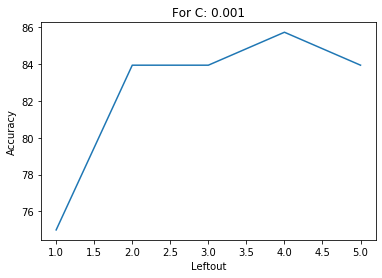

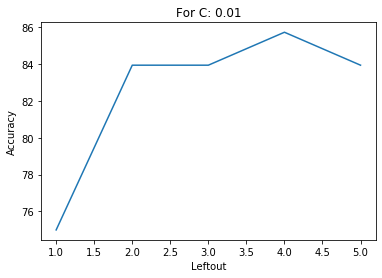

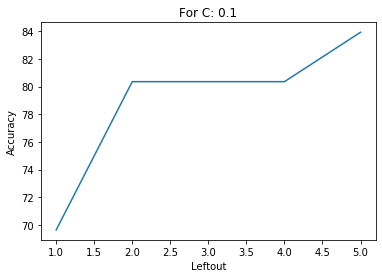

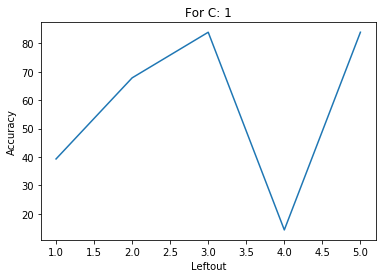

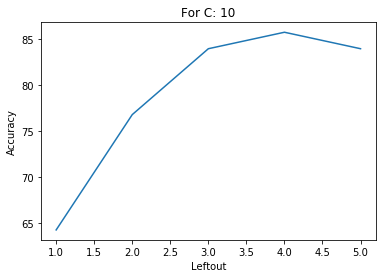

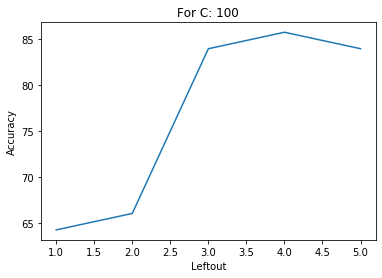

Accuracy with different C values: [82.5        82.5        78.92857143 57.85714286 78.92857143 76.78571429]

True positive for C(0.01): 0
True negative for C(0.01): 95
False negative for C(0.01): 0
False negative for C(0.01): 20
Recall: 0.0
Precision: 0
FDR: 0
NPV: 0.8260869565217391
FPR: 0.0
f1: 0
f2: 0
REAL->     Pos.        Neg.   
     |--------------------------|
Pos. |    0        0           |
Neg. |    20        95           |
     |--------------------------|
Total Accuracy with best C(0.01)= 82.6086956521739

True positive for C(0.1): 2
True negative for C(0.1): 94
False negative for C(0.1): 1
False negative for C(0.1): 18
Recall: 0.1
Precision: 0.6666666666666666
FDR: 0.3333333333333333
NPV: 0.8392857142857143
FPR: 0.010526315789473684
f1: 1.7391304347826086
f2: 1.2048192771084336
REAL->     Pos.        Neg.   
     |--------------------------|
Pos. |    2        1           |
Neg. |    18        94           |
     |--------------------------|
Total Accuracy with best C(0.1

In [127]:
validAcc = np.zeros((6,5))
SVMDecideC(validAcc)
training_mean_accuracy = np.mean(validAcc, axis=1)
print("Accuracy with different C values: " + str(training_mean_accuracy))
print()
bestC = CINT[np.argmax(training_mean_accuracy)]

for CI in CINT:
    validAcc = np.zeros((6,5))
    if(CI != bestC):
        validAcc = NormalSVM(CI, testFeat)
        print("Total Accuracy with best C(" + str(CI) + ")= "  + str(validAcc))
        print()
print("Micro averages precision for gamma values: "+ str(truePosC/(truePosC + falsePosC)))
print("Macro averages precision for gamma values: "+ str(presG/6)) 
validAcc1 = np.zeros((6,5))
validAcc1 = NormalSVM(bestC, testFeat)
print("Total Accuracy with best C(" + str(bestC) + ")= "  + str(validAcc1))


In [128]:
def RBFDecideGamma(validAccRBF):
    for g in range(6):
        classifier = svm.SVC(C=1e4,gamma=GINT[g], kernel='rbf')
        for i in range(5):
            classifier.fit(x_train_folds[i], y_train_folds[i])
            y_pred = classifier.predict(x_regular_folds[i])
            validAccRBF[g][i] = np.sum(y_pred==y_regular_folds[i]) / len(y_regular_folds[i]) * 100

In [133]:
def RBFSVM(bestG, testFeat):
    truePos = 0
    trueNeg = 0
    falsePos = 0
    falseNeg = 0
    classifier = svm.SVC(C=1e4, gamma=bestG, kernel='rbf')
    classifier.fit(x_train, trainBin)
    y_pred = classifier.predict(testFeat)
    for i in range(115):
        if(y_pred[i] == y_test[i]):
            if (y_pred[i] == 0):
                trueNeg += 1
            elif(y_pred[i] == 1):
                truePos += 1
        else:
            if (y_pred[i] == 0):
                falseNeg += 1
            elif(y_pred[i] == 1):
                falsePos += 1

    test_accuracy = np.sum(y_pred==y_test) / len(y_test) * 100
    print("True positive for Gamma("+ str(bestG)+ "): " + str(truePos))
    print("True negative for Gamma("+ str(bestG)+ "): "+ str(trueNeg))
    print("False negative for Gamma("+ str(bestG)+ "): "+ str(falsePos))
    print("False negative for Gamma("+ str(bestG)+ "): "+ str(falseNeg))
    showValues(truePos, trueNeg, falsePos, falseNeg, 1)
    test_accuracy = np.sum(y_pred==y_test) / len(y_test) * 100
    return test_accuracy

In [137]:
def RBFSVMMUL(bestG, train_labels, test_labels):
    global truePosG
    global falsePosG
    truePos = 0
    trueNeg = 0
    falsePos = 0
    falseNeg = 0
    classifier = svm.SVC(C=1e10, gamma=bestG, kernel='rbf')
    classifier.fit(x_train, train_labels)
    y_pred = classifier.predict(testFeat)
    for i in range(115):
        if(y_pred[i] == y_test[i]):
            if (y_pred[i] == 0):
                trueNeg += 1
            elif(y_pred[i] == 1):
                truePos += 1
        else:
            if (y_pred[i] == 0):
                falseNeg += 1
            elif(y_pred[i] == 1):
                falsePos += 1    
    truePosG += truePos
    falsePosG += falsePos
    print("True positive for Gamma("+ str(bestG)+ "): " + str(truePos))
    print("True negative for Gamma("+ str(bestG)+ "): "+ str(trueNeg))
    print("False negative for Gamma("+ str(bestG)+ "): "+ str(falsePos))
    print("False negative for Gamma("+ str(bestG)+ "): "+ str(falseNeg))
    showValues(truePos, trueNeg, falsePos, falseNeg, 1)
    test_accuracy = np.sum(y_pred==test_labels) / len(test_labels) * 100
    return test_accuracy

In [138]:
# Q3 PART2 RBF WITH GAMMA DISTRIBUTION
validAccRBF = np.zeros((6,5))
RBFDecideGamma(validAccRBF)
training_mean_accuracy_rbf = np.mean(validAccRBF, axis=1)
bestG = GINT[np.argmax(training_mean_accuracy_rbf)]
for GI in GINT:
    validAccRBF = np.zeros((6,5))
    if(GI != bestG):
        validAccRBF = RBFSVM(GI, testFeat)
        print("Total Accuracy with Gamma(" + str(GI) + ")= "  + str(validAccRBF))
        print()
try:
    print("Micro averages precision for gamma values: "+ str(truePosG/(truePosG + falsePosG)))
except (ZeroDivisionError):
    print("Micro averages precision for gamma values: "+ str(0))
    

print("Macro averages precision for gamma values: "+ str(presG/6))
validAccRBF = np.zeros((6,5))
validAccRBF1 = RBFSVM(bestG, testFeat)
print("Total Accuracy with best Gamma(" + str(bestG) + ")= "  + str(validAccRBF1))

True positive for Gamma(0.125): 0
True negative for Gamma(0.125): 95
False negative for Gamma(0.125): 0
False negative for Gamma(0.125): 20
Recall: 0.0
Precision: 0
FDR: 0
NPV: 0.8260869565217391
FPR: 0.0
f1: 0
f2: 0
REAL->     Pos.        Neg.   
     |--------------------------|
Pos. |    0        0           |
Neg. |    20        95           |
     |--------------------------|
Total Accuracy with Gamma(0.125)= 82.6086956521739

True positive for Gamma(0.25): 0
True negative for Gamma(0.25): 95
False negative for Gamma(0.25): 0
False negative for Gamma(0.25): 20
Recall: 0.0
Precision: 0
FDR: 0
NPV: 0.8260869565217391
FPR: 0.0
f1: 0
f2: 0
REAL->     Pos.        Neg.   
     |--------------------------|
Pos. |    0        0           |
Neg. |    20        95           |
     |--------------------------|
Total Accuracy with Gamma(0.25)= 82.6086956521739

True positive for Gamma(0.5): 0
True negative for Gamma(0.5): 95
False negative for Gamma(0.5): 0
False negative for Gamma(0.5): 20
R

In [141]:
# Q3 PART2 RBF WITH MULTIPLE CONTENT(0,1,2)

train_mul_features = train_multiclass_labels.values
test_mul_features = test_multiclass_labels.values
train_mul_features = np.transpose(train_mul_features)[1]
test_mul_features = np.transpose(test_mul_features)[1]
validAccRBF = RBFSVMMUL(bestG, train_mul_features, test_mul_features)
try:
    print("Micro averages precision for multiple label values: "+ str(truePosG/(truePosG + falsePosG)))
except (ZeroDivisionError):
    print("Micro averages precision for multiple label values: "+ str(0))
    

print("Macro averages precision for multiple label values: "+ str(presG/2))

print("Total Accuracy with multiple label input: "  + str(validAccRBF))

True positive for Gamma(0.0625): 4
True negative for Gamma(0.0625): 78
False negative for Gamma(0.0625): 12
False negative for Gamma(0.0625): 16
Recall: 0.2
Precision: 0.25
FDR: 0.75
NPV: 0.8297872340425532
FPR: 0.13333333333333333
f1: 1.1111111111111112
f2: 1.0416666666666667
REAL->     Pos.        Neg.   
     |--------------------------|
Pos. |    4        12           |
Neg. |    16        78           |
     |--------------------------|
Micro averages precision for multiple label values: 0.25
Macro averages precision for multiple label values: 0.375
Total Accuracy with multiple label input: 46.08695652173913
